In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras import regularizers
from IPython.display import Image
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast, Rescaling

In [2]:
! unzip /content/drive/MyDrive/Combined_Dataset.zip
dataset_dir = "/content/content/AIRecognition"

Streaming output truncated to the last 5000 lines.
  inflating: content/AIRecognition/fake/fake-v2/13943.png  
  inflating: content/AIRecognition/fake/fake-v2/2587.jpg  
  inflating: content/AIRecognition/fake/fake-v2/11963.jpg  
  inflating: content/AIRecognition/fake/fake-v2/20878.png  
  inflating: content/AIRecognition/fake/fake-v2/13839.png  
  inflating: content/AIRecognition/fake/fake-v2/19956.png  
  inflating: content/AIRecognition/fake/fake-v2/22093.png  
  inflating: content/AIRecognition/fake/fake-v2/2704.jpg  
  inflating: content/AIRecognition/fake/fake-v2/16898.png  
  inflating: content/AIRecognition/fake/fake-v2/20703.png  
  inflating: content/AIRecognition/fake/fake-v2/23931.png  
  inflating: content/AIRecognition/fake/fake-v2/17039.png  
  inflating: content/AIRecognition/fake/fake-v2/2647.jpg  
  inflating: content/AIRecognition/fake/fake-v2/24691.png  
  inflating: content/AIRecognition/fake/fake-v2/19245.png  
  inflating: content/AIRecognition/fake/fake-v2/1372

In [4]:
img_height = 224
img_width = 224
batch_size = 100

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  shuffle=True,
  subset="training",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    RandomRotation(0.2),  # Randomly rotate images by 20%
    RandomZoom(0.2),  # Randomly zoom into images
    RandomContrast(0.2),  # Randomly adjust contrast
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

class_names = train_ds.class_names

Found 27548 files belonging to 2 classes.
Using 22039 files for training.
Found 27548 files belonging to 2 classes.
Using 5509 files for validation.


In [10]:
# Building the Transfer Learning model using EfficientNetV2B0
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_height, img_width, 3),
    # pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs, training = False)
gap = GlobalAveragePooling2D()(x)
gmp = GlobalMaxPooling2D()(x)
x = Concatenate()([gap, gmp])
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
EfficientNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)           5919312   ['input_12[0][0]']            
 nal)                                                                                             
                                                                                                  
 global_average_pooling2d_4  (None, 1280)                 0         ['efficientnetv2-b0[0][0]']   
  (GlobalAveragePooling2D)                                                                        
                                                                                              

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

EfficientNet_model_history = EfficientNet_model.fit(
    augmented_train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
EfficientNet_model.save('EfficientNet_arch2')

Epoch 1/100
221/221 [==============================] - 395s 2s/step - loss: 0.3968 - accuracy: 0.8426 - precision: 0.8126 - recall: 0.7186 - val_loss: 0.2010 - val_accuracy: 0.9212 - val_precision: 0.9453 - val_recall: 0.8250
Epoch 2/100
221/221 [==============================] - 342s 2s/step - loss: 0.2288 - accuracy: 0.9108 - precision: 0.8919 - recall: 0.8497 - val_loss: 0.1970 - val_accuracy: 0.9252 - val_precision: 0.9632 - val_recall: 0.8199
Epoch 3/100
221/221 [==============================] - 347s 2s/step - loss: 0.1899 - accuracy: 0.9266 - precision: 0.9142 - recall: 0.8736 - val_loss: 0.1856 - val_accuracy: 0.9268 - val_precision: 0.9708 - val_recall: 0.8179
Epoch 4/100
221/221 [==============================] - 343s 2s/step - loss: 0.1737 - accuracy: 0.9318 - precision: 0.9220 - recall: 0.8808 - val_loss: 0.1967 - val_accuracy: 0.9270 - val_precision: 0.9795 - val_recall: 0.8107
Epoch 5/100
221/221 [==============================] - 345s 2s/step - loss: 0.1587 - accuracy: 0

In [12]:
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

56/56 [==============================] - 35s 533ms/step - loss: 0.1310 - accuracy: 0.9553 - precision: 0.9580 - recall: 0.9138
Val Loss: 0.1310
Val Accuracy: 0.9553
Val Precision: 0.9580
Val Recall: 0.9138


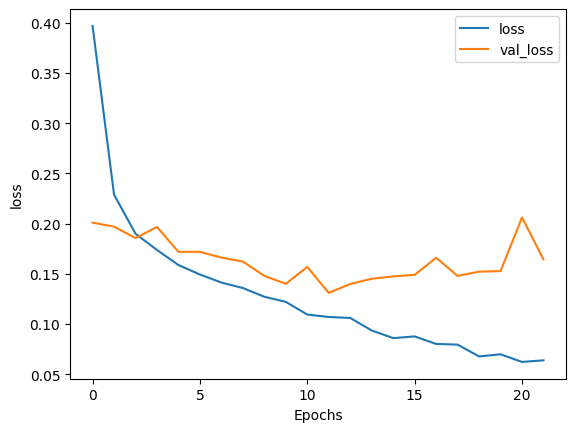

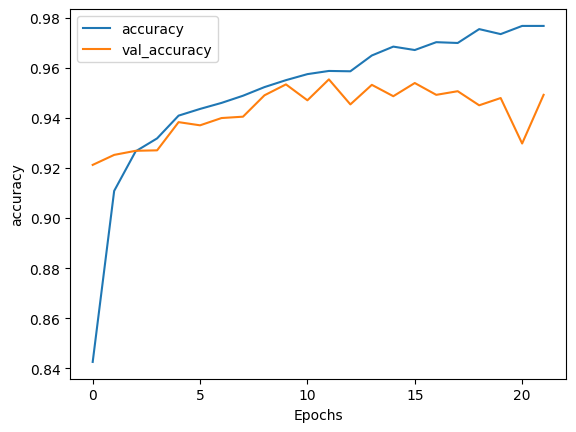

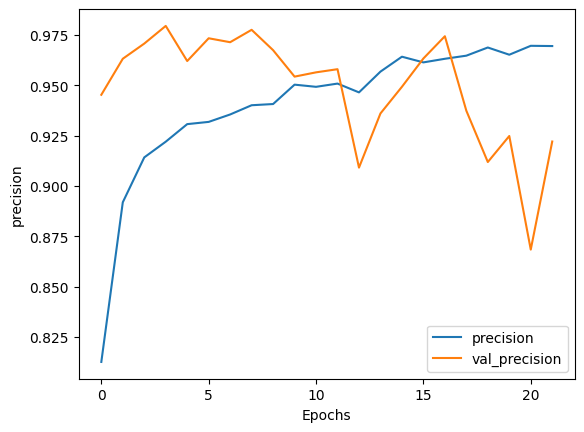

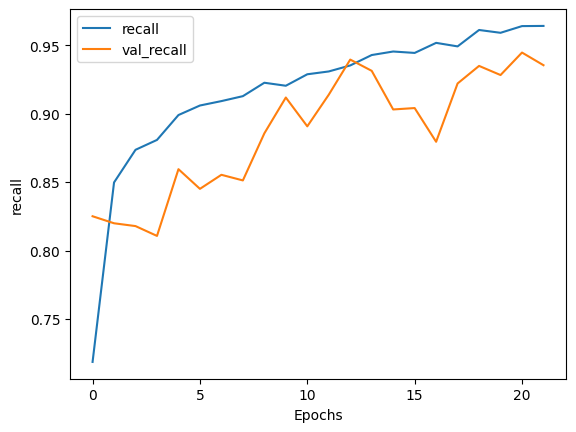

In [15]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_metrics(EfficientNet_model_history, 'loss')
plot_metrics(EfficientNet_model_history, 'accuracy')
plot_metrics(EfficientNet_model_history, 'precision')
plot_metrics(EfficientNet_model_history, 'recall')